In [1]:
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.spatial.distance import pdist
from collections import defaultdict
from scipy.stats import hypergeom
from collections import Counter
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/yeast"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"
ANNOTATION_DIRECTORY = f"{YEAST_DIRECTORY}/annotations"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"

# Preparation

### Load stuff

In [3]:
aspect = 'BP'

lb_GO = 5
ub_GO = 5000
min_lvl = 0
max_lvl = 100

In [3]:
PPI = nx.read_edgelist(f"{NETWORK_DIRECTORY}/PPI_BioGRID.txt")
GDV = graco.orbits(PPI)
GCV = graco.coefficients(PPI)

annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{aspect}_BioGRID-SGD.csv")
go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")
gene_population = set(PPI.nodes())
GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (lb_GO <= len(annotation_df[annotation_df.GO_ID == go_id]) <= ub_GO and
                               min_lvl <= go_dag[go_id].level <= max_lvl)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

NameError: name 'aspect' is not defined

### Convenient dictionaries

In [5]:
# Conversion dictionaries
GO2genes = pd.Series({go_id: set(genes.Systematic_ID) for go_id, genes in annotation_df.groupby('GO_ID')}, 
                     name='nb_genes')

gene2GO  = {gene : set(go_ids.GO_ID) for gene, go_ids in annotation_df.groupby('Systematic_ID')}
global_GO_counter = GO2genes.apply(len)

# Start

In [5]:
G = nx.erdos_renyi_graph(2**7,0.05)
GCV = graco.coefficients(G)

assert nx.is_connected(G)

for distance in ['euclidean', 'cityblock', 'sqeuclidean',
                 'cosine', 'correlation', 'chebyshev',
                 'canberra', 'braycurtis']:
    D1 = graco.GCV_distance( GCV, distance)
    D2 = graco.GCV_distance2(GCV, distance)
    print(np.isclose(D1,D2).all())
    if not np.isclose(D1,D2).all():
        break

True
True
True
True
False


In [47]:
D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)

eq = ('O', 'G1-f')
coeffs = GCV[eq]

gcv = coeffs.dropna()
print(eq, D_all.loc[78,0])
print()

not_nan_indices = gcv.index
nan_indices = GCV.index[coeffs.isna().any(axis=1)]

D_sub = graco.distance_matrix(gcv, distance)
D_all.loc[not_nan_indices,not_nan_indices] += D_sub/2
Divisor.loc[not_nan_indices,not_nan_indices] += 1


('O', 'G1-f') 0



In [64]:
4*19

76

In [71]:
graco.distance_matrix(gcv, distance)[78,72]

nan

In [87]:
pdist(gcv.iloc[[78,76]], 'correlation')

array([0.])

In [86]:
gcv.iloc[[78,72, 76]]

Orbit        12         8
85     0.000000  1.000000
78     0.500000  0.500000
83     0.166667  0.833333

In [58]:
gcv

Orbit        12         8
0      0.000000  1.000000
1      0.000000  1.000000
2      0.000000  1.000000
3      0.000000  1.000000
4      0.083333  0.916667
..          ...       ...
123    0.000000  1.000000
124    0.111111  0.888889
125    0.000000  1.000000
126    0.000000  1.000000
127    0.200000  0.800000

[117 rows x 2 columns]

In [226]:
GDV = np.array([
#    0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14
    [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    ])

GCV = graco.coefficients(GDV)

In [227]:
GCV['A']

Equation         0              1                   2              3          
Orbit            1         3   10   13    4    8   10   13    6   12   14    9
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  NaN  NaN
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  NaN  NaN
2         0.000000  1.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3         1.000000  0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0

In [3]:
GDV = np.array([
        #                    0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14
                            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                            [1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
                            ])

GCV = graco.coefficients(GDV)

In [4]:
GCV

Group            A                                                    ...  \
Equation         0              1                   2              3  ...   
Orbit            1         3   10   13    4    8   10   13    6   12  ...   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
2         0.000000  1.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3         1.000000  0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...   

Group       O                                            
Equation G1-f     G2-a     G2-b     G2-c      G2-d       
Orbit      12   8   12  14   13  14   10   13   11   13  
0         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
1         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
2         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  1.0  0.0  
3         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  

[4 rows x 62 columns]

In [5]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    coeffs.fillna(coeffs.mean(), inplace=True)
    continue
    GCV.loc[:,eq] = coeffs.copy()

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:
coeffs.fillna(coeffs.mean(), inplace=True)

In [5]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    GCV.loc[:,eq].fillna(GCV.loc[:,eq].mean(), inplace=True)

In [4]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    GCV.loc[:,eq].fillna(np.mean(GCV.loc[:,eq]), inplace=True)

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [9]:
coeffs.fillna(coeffs.mean(), inplace=True)

In [10]:
coeffs

Group       O     
Equation G2-d     
Orbit      11   13
0         1.0  0.0
1         1.0  0.0
2         1.0  0.0
3         1.0  0.0

In [205]:
GCV.loc[:,eq] == coeffs

ValueError: Can only compare identically-labeled DataFrame objects

In [216]:
GCV.loc[:,eq]

Orbit   11   13
0      NaN  NaN
1      NaN  NaN
2      1.0  0.0
3      NaN  NaN

In [206]:
coeffs

Group       O     
Equation G2-d     
Orbit      11   13
0         NaN  NaN
1         NaN  NaN
2         1.0  0.0
3         NaN  NaN

In [204]:
np.mean(coeffs)

Group  Equation  Orbit
O      G2-d      11       1.0
                 13       0.0
dtype: float64

In [174]:
GCV.loc[:,eq].fillna(1/len(coeffs.T), inplace=True)

In [175]:
GCV

Group            A                                                    ...  \
Equation         0              1                   2              3  ...   
Orbit            1         3   10   13    4    8   10   13    6   12  ...   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
2         0.000000  1.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3         1.000000  0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...   

Group       O                                            
Equation G1-f     G2-a     G2-b     G2-c      G2-d       
Orbit      12   8   12  14   13  14   10   13   11   13  
0         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  0.5  0.5  
1         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  0.5  0.5  
2         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  1.0  0.0  
3         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  0.5  0.5  

[4 rows x 62 columns]

In [153]:
def fill_nan(GCV, value='barycenter'):
    
    lowest_two_levels = list(range(GCV.columns.nlevels-1))
    
    if not lowest_two_levels:
        pass
    
    else:
        if value == 'barycenter':
            for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                                          axis  = 1):
                GCV.loc[:,eq].fillna(1/len(coeffs.T), inplace=True)
        if value == 'mean':
            for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                                          axis  = 1):
                GCV.loc[:,eq].fillna(coeffs.mean(), inplace=True)

In [140]:
gcv = GCV.loc[:,eq]

In [147]:
gcv.fillna(gcv.mean())

Orbit   11   13
0      1.0  0.0
1      1.0  0.0
2      1.0  0.0
3      1.0  0.0

Orbit
11    1.0
13    0.0
dtype: float64

In [126]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    GCV.loc[:,eq].fillna(1/len(coeffs.T), inplace=True)

In [127]:
GCV

Group            A                                                        \
Equation         0               1                           2             
Orbit            1         3    10    13     4     8        10        13   
0         0.333333  0.666667  1.00  0.00  0.00  0.00  1.000000  0.000000   
1         0.333333  0.666667  1.00  0.00  0.00  0.00  1.000000  0.000000   
2         0.000000  1.000000  0.25  0.25  0.25  0.25  0.333333  0.333333   
3         1.000000  0.000000  0.25  0.25  0.25  0.25  0.333333  0.333333   

Group                         ...    O                                     \
Equation                   3  ... G1-f      G2-a      G2-b      G2-c        
Orbit            6        12  ...   12    8   12   14   13   14   10   13   
0         0.000000  0.333333  ...  0.5  0.5  0.5  0.5  0.5  0.5  1.0  0.0   
1         0.000000  0.333333  ...  0.5  0.5  0.5  0.5  0.5  0.5  1.0  0.0   
2         0.333333  0.333333  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
3         0.333333  0.000000  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5   

Group               
Equation G2-d       
Orbit      11   13  
0         0.5  0.5  
1         0.5  0.5  
2         1.0  0.0  
3         0.5  0.5  

[4 rows x 62 columns]

In [119]:
GCV[eq].fillna(1/len(coeffs.T))

Orbit    10    13     4     8
0      1.00  0.00  0.00  0.00
1      1.00  0.00  0.00  0.00
2      0.25  0.25  0.25  0.25
3      0.25  0.25  0.25  0.25

In [121]:
? GCV.fillna

In [110]:
GCV[eq].fillna()

Orbit         1         3
0      0.333333  0.666667
1      0.333333  0.666667
2      0.000000  1.000000
3      1.000000  0.000000

In [ ]:
# ==================== !!!!! =======================
# NEED FOR FUNCTION: fill_nan(GCV, nan='barycenter')
# ==================== !!!!! =======================

In [97]:
GCV

Group            A                                                    ...  \
Equation         0              1                   2              3  ...   
Orbit            1         3   10   13    4    8   10   13    6   12  ...   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
2         0.000000  1.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3         1.000000  0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...   

Group       O                                            
Equation G1-f     G2-a     G2-b     G2-c      G2-d       
Orbit      12   8   12  14   13  14   10   13   11   13  
0         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
1         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
2         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  1.0  0.0  
3         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  

[4 rows x 62 columns]

In [93]:
gcv = GCV.loc[[0,'NULL']]
d2 = graco.GCV_distance(GCV, 'cityblock')

In [94]:
d2

0         1         2         3      NULL
0     0.000000  0.000000  0.444444  0.777778       inf
1     0.000000  0.000000  0.444444  0.777778       inf
2     0.444444  0.444444  0.000000  1.000000       inf
3     0.777778  0.777778  1.000000  0.000000  0.656463
NULL       inf       inf       inf  0.656463  0.000000

In [95]:
gcv

Group            A                                                    \
Equation         0                   1                                 
Orbit            1         3        10        13         4         8   
0         0.333333  0.666667  1.000000  0.000000  0.000000  0.000000   
NULL      0.333333  0.666667  0.166667  0.333333  0.166667  0.333333   

Group                                             ...    O                   \
Equation         2                             3  ... G1-f       G2-a         
Orbit           10        13         6        12  ...   12    8    12    14   
0         1.000000  0.000000  0.000000       NaN  ...  NaN  NaN   NaN   NaN   
NULL      0.333333  0.333333  0.333333  0.333333  ...  0.5  0.5  0.25  0.75   

Group                                               
Equation  G2-b            G2-c           G2-d       
Orbit       13    14        10        13   11   13  
0          NaN   NaN  1.000000  0.000000  NaN  NaN  
NULL      0.25  0.75  0.333333  0.666667  0.5  0.5  

[2 rows x 62 columns]

In [46]:
D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)

lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    
    if D_all.isna().any().any():
        break

    gcv = coeffs.dropna()
    print(eq, D_all.loc[78,0])
    print()

    not_nan_indices = gcv.index
    nan_indices = GCV.index[coeffs.isna().any(axis=1)]
    
    if 78 in nan_indices:
        print("HAAAALT")
        break

    assert (coeffs.isna().any(axis=1) == coeffs.isna().all(axis=1)).all()
    assert len(nan_indices) + len(not_nan_indices) == len(GCV)

    D_sub = graco.distance_matrix(gcv, distance)
    D_all.loc[not_nan_indices,not_nan_indices] += D_sub/2
    Divisor.loc[not_nan_indices,not_nan_indices] += 1

D_fin = D_all / Divisor

('A', '0') 0

('A', '1') 5.551115123125783e-17

('A', '2') 0.0016797031844373311

('A', '3') 0.002263865578477242

('D', '0') 0.17493703022448864

('D', '1') 0.1749370302244887

('D', '2') 0.17873673364043535

('D', '3') 0.18131185805688044

('G', '0-0') 0.18131185805688044

('G', '1-1') 0.1813118580568805

('G', '1-2') 0.1824283461402122

('G', '2-1') 0.1825344289887147

('G', '3-3') 0.1860632942512524

('O', 'G1-a') 0.1860632942512524

('O', 'G1-b') 0.18606329425125245

('O', 'G1-c') 0.18606329425125245

('O', 'G1-d') 0.1860632942512525

('O', 'G1-e') 0.1860632942512525

('O', 'G1-f') 0.18606329425125256



In [45]:
coeffs

Group            A          
Equation         0          
Orbit            1         3
0         1.000000  0.000000
1         0.925926  0.074074
2         0.935484  0.064516
3         0.955556  0.044444
4         0.894737  0.105263
..             ...       ...
123       0.959184  0.040816
124       0.901639  0.098361
125       0.952381  0.047619
126       0.902439  0.097561
127       0.848485  0.151515

[128 rows x 2 columns]

In [38]:
D_all.isna().any().any()

False

In [35]:
GCV[('O','G1-f')].isna().any()

Orbit
12    True
8     True
dtype: bool

In [24]:
78 in nan_indices

False

In [22]:
D_all.loc[78]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
123   NaN
124   NaN
125   NaN
126   NaN
127   NaN
Name: 78, Length: 128, dtype: float64

In [12]:
GCV.loc[78].head(60)

Group  Equation  Orbit
A      0         1        0.960784
                 3        0.039216
       1         10       0.036496
                 13       0.000000
                 4        0.948905
                 8        0.014599
       2         10       0.051546
                 13       0.000000
                 6        0.948454
       3         12       0.444444
                 14       0.000000
                 9        0.555556
D      0         2        0.952381
                 3        0.047619
       1         10       0.034014
                 12       0.013605
                 5        0.938776
                 8        0.013605
       2         11       0.100000
                 13       0.000000
                 7        0.900000
       3         11       1.000000
                 13       0.000000
                 14       0.000000
G      0-0       1        0.960784
                 3        0.039216
       1-1       12       0.014388
                 4        0.9352

In [8]:
D2[78]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
123   NaN
124   NaN
125   NaN
126   NaN
127   NaN
Name: 78, Length: 128, dtype: float64

In [50]:
GCV.iloc[39].head(60)

Group  Equation  Orbit
A      0         1        0.954545
                 3        0.045455
       1         10       0.035857
                 13       0.000000
                 4        0.868526
                 8        0.095618
       2         10       0.081818
                 13       0.000000
                 6        0.918182
       3         12       0.666667
                 14       0.000000
                 9        0.333333
D      0         2        0.964286
                 3        0.035714
       1         10       0.030612
                 12       0.013605
                 5        0.874150
                 8        0.081633
       2         11       0.074074
                 13       0.000000
                 7        0.925926
       3         11       1.000000
                 13       0.000000
                 14       0.000000
G      0-0       1        0.954545
                 3        0.045455
       1-1       12       0.016000
                 4        0.8720

In [6]:
D1.index[D1.iloc[0,:] != D2.iloc[0,:]]

Int64Index([78], dtype='int64')

In [41]:
G[39]

AtlasView({10: {}, 38: {}, 41: {}, 44: {}, 78: {}, 111: {}, 114: {}, 118: {}})

In [40]:
D1.iloc[2,39]

nan

In [56]:
for i in range(10):
    G = nx.erdos_renyi_graph(2**8+1,0.1)
    GDV = graco.orbits(G)
    print(GDV['3' ].sum() % 3 == 0 and GDV['0'].sum() % 2 == 0 and 
          GDV['14'].sum() % 4 == 0)

True
True
True
True
True
True
True
True
True
True


In [59]:
GDV = np.array([[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])
GCV = graco.coefficients(GDV)

In [6]:
G = nx.Graph()
G.add_edges_from([(0,1),(0,2),(1,2),(2,3)])
GDV = graco.orbits(G)

In [7]:
GCV = graco.coefficients(GDV)

In [31]:
GDV = np.array([
        #                    0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14
                            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                            [1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                            [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                            ])
GCV = graco.coefficients(GDV)

In [32]:
index = list(range(len(GDV)-1)) + ['NULL']
GCV.index = index

In [41]:
gcv = GCV.loc[[0,'NULL']]

In [71]:
for a,b in GCV.groupby(level=[0,1], axis=1):
    break

In [74]:
depth = len(GCV.columns.levels)
GCV.columns.droplevel([depth-1]).unique()

MultiIndex([('A',    '0'),
            ('A',    '1'),
            ('A',    '2'),
            ('A',    '3'),
            ('D',    '0'),
            ('D',    '1'),
            ('D',    '2'),
            ('D',    '3'),
            ('G',  '0-0'),
            ('G',  '1-1'),
            ('G',  '1-2'),
            ('G',  '2-1'),
            ('G',  '3-3'),
            ('O', 'G1-a'),
            ('O', 'G1-b'),
            ('O', 'G1-c'),
            ('O', 'G1-d'),
            ('O', 'G1-e'),
            ('O', 'G1-f'),
            ('O', 'G2-a'),
            ('O', 'G2-b'),
            ('O', 'G2-c'),
            ('O', 'G2-d')],
           names=['Group', 'Equation'])

In [149]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels, 
                                          axis  = 1):
    gcv = GCV[eq].dropna()
    break

In [153]:
len(gcv.T)

2

In [154]:
eq

('A', '0')

In [147]:
for eq, gdv in list(range(GCV.columns.nlevels-1)):
    gcv = GCV[eq].dropna()
    break

TypeError: 'int' object is not iterable

In [146]:
eq

'0-0'

In [126]:
GCV.columns.get_level_values(0)

Index(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O'],
      dtype='object', name='Group')

In [125]:
? m.slice_indexer

In [117]:
slice(2)

slice(None, 2, None)

In [115]:
? slice

In [102]:
gdv

Group            A                   D          
Equation         0                   0          
Orbit            1         3         2         3
0         0.333333  0.666667  0.000000  1.000000
1         0.333333  0.666667  0.000000  1.000000
2         0.000000  1.000000  0.666667  0.333333
3         1.000000  0.000000       NaN       NaN
NULL      0.333333  0.666667  1.000000  1.000000

In [91]:
b

Group       O     
Equation G2-d     
Orbit      11   13
0         NaN  NaN
1         NaN  NaN
2         1.0  0.0
3         NaN  NaN
NULL      0.5  0.5

In [6]:
dict_gdv_gdv = {}
dict_gdv_can = {}
dict_ran = {}

go_term = next(iter(GO_population))

positives = GO2genes[go_term]

gdv_signature = GDV.loc[positives].mean()
gcv_signature = GCV.loc[positives].mean()

In [7]:
gcv_signature['O']

Equation  Orbit
G1-a      11       0.422603
          7        0.577397
G1-b      5        0.874415
          8        0.125585
G1-c      6        0.955502
          9        0.044498
G1-d      12       0.032101
          9        0.967899
G1-e      4        0.985936
          8        0.014064
G1-f      12       0.646117
          8        0.353883
G2-a      12       0.992605
          14       0.007395
G2-b      13       0.557192
          14       0.442808
G2-c      10       0.998406
          13       0.001594
G2-d      11       0.689371
          13       0.310629
dtype: float64

In [ ]:
D_gdv_gdv = graco.distance_matrix(GDV, 'GDV_similarity')
D_gdv_can = graco.distance_matrix(GDV, 'canberra')

y_true  = pd.Series(GDV.index.isin(positives), index=GDV.index)

y_score_gdv_gdv = pd.Series({name:1-graco.distance(gdv_signature, row, 'GDV_similarity') for name, row in GDV.iterrows()})
y_score_gdv_can = pd.Series({name:1-graco.distance(gcv_signature, row, 'GDV_similarity') for name, row in GDV.iterrows()})

y_score_ran = pd.Series(np.random.uniform(size=len(GCV)), index=GCV.index).drop('NULL')

dict_gdv_gdv[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_gdv_gdv)
dict_gdv_can[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_gdv_can)

dict_ran[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_ran)

In [6]:
dict_gdv_gdv = {}
dict_gdv_can = {}
dict_ran = {}

for nr,go_term in enumerate(GO_population):
    
    print(f"{100*nr/len(GO_population):.3f}%", end='\r')
    
    positives = GO2genes[go_term]
    
    gdv_signature = GDV.loc[positives].mean()
    gcv_signature = GCV.loc[positives].mean()

    GDV.loc['NULL'] = gdv_signature.round().astype(int)
    GCV.loc['NULL'] = gcv_signature
    
    D_gdv_gdv = graco.distance_matrix(GDV, 'GDV_similarity')
    D_gdv_can = graco.distance_matrix(GDV, 'canberra')

    y_true  = pd.Series(GDV.index.isin(positives), index=GDV.index).drop('NULL')
    
    y_score_gdv_gdv = pd.Series(1-D_gdv_gdv[-1], index=GDV.index).drop('NULL')
    y_score_gdv_can = pd.Series(1-D_gdv_can[-1], index=GDV.index).drop('NULL')

    y_score_ran = pd.Series(np.random.uniform(size=len(GCV)), index=GCV.index).drop('NULL')
    
    dict_gdv_gdv[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_gdv_gdv)
    dict_gdv_can[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_gdv_can)

    dict_ran[go_term] = roc_auc_score(y_true=y_true, y_score=y_score_ran)
    
    if nr == 10:
        break

In [10]:
np.array([[0,1,2,3,4,5]]).shape

(1, 6)

In [11]:
GDV = np.array([[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]])
graco.coefficients(np.array(GDV))

Group            A                                                    \
Equation         0                   1                                 
Orbit            1         3        10        13         4         8   
0         0.142857  0.857143  0.178571  0.464286  0.071429  0.285714   

Group                                         ...    O                 \
Equation         2                         3  ... G1-f           G2-a   
Orbit           10        13         6    12  ...   12    8        12   
0         0.344828  0.448276  0.206897  0.32  ...  0.6  0.4  0.222222   

Group                                                                           
Equation                G2-b                G2-c                G2-d            
Orbit           14        13        14        10        13        11        13  
0         0.777778  0.236364  0.763636  0.277778  0.722222  0.458333  0.541667  

[1 rows x 62 columns]

In [11]:
max(s_gdv_can.values()), max(s_gdv_gdv.values()), max(s_ran.values())

NameError: name 's_gdv_can' is not defined

In [85]:
good_go_terms = s1[s1>0.99].index
print(good_go_terms)

Index(['GO:0001109', 'GO:0051418', 'GO:0051417', 'GO:0019249', 'GO:0001111'], dtype='object')


In [10]:
s1 = pd.Series(dict_gdv_gdv)
s2 = pd.Series(dict_gdv_can)
s3 = pd.Series(dict_ran)

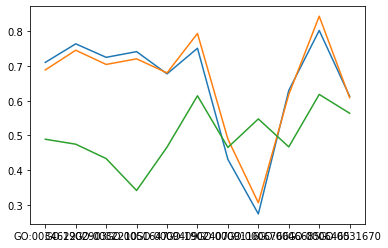

In [15]:
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)

In [12]:
g1 = s1[good_go_terms]
g2 = s2[good_go_terms]
g3 = s3[good_go_terms]

NameError: name 'good_go_terms' is not defined

In [13]:
plt.plot(g1[:100].values)
plt.plot(g2[:100].values)
plt.plot(g3[:100].values)

NameError: name 'g1' is not defined

In [88]:
len(GO2genes['GO:0051417'])

1

In [82]:
bad_go_terms = s3[s3>0.9].index

In [84]:
for go_term in bad_go_terms:
    print(len(GO2genes[go_term]))

2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
2


In [53]:
#fpr_gdv_gdv, tpr_gdv_gdv, _ = roc_curve(y_true=y_true, y_score=y_score_gdv_gdv)
#fpr_gdv_can, tpr_gdv_can, _ = roc_curve(y_true=y_true, y_score=y_score_gdv_can)

#fpr_ran, tpr_ran, _ = roc_curve(y_true=y_true, y_score=y_score_ran)


#fpr_gdv_gdv, tpr_gdv_gdv, _ = precision_recall_curve(y_true=y_true, probas_pred=y_score_gdv_gdv)
#fpr_gdv_can, tpr_gdv_can, _ = precision_recall_curve(y_true=y_true, probas_pred=y_score_gdv_can)

#fpr_ran, tpr_ran, _ = precision_recall_curve(y_true=y_true, probas_pred=y_score_ran)

NameError: name 'fpr_gdv_gdv' is not defined

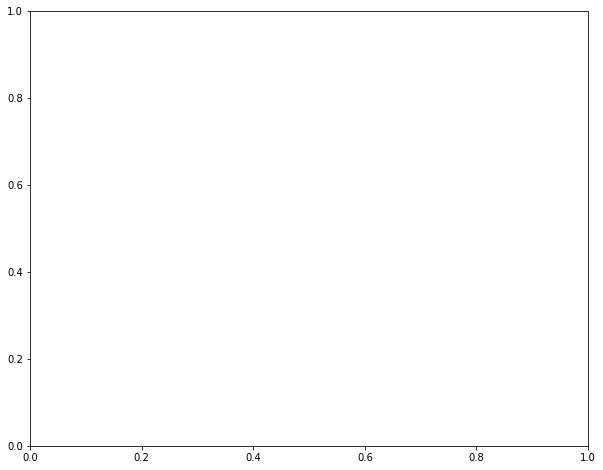

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
fig.patch.set_alpha(0)


ax.plot(fpr_gdv_gdv,tpr_gdv_gdv, linewidth=3, label='GDV-similarity');
ax.plot(fpr_gdv_can,tpr_gdv_can, linewidth=3, label='Canberra');

ax.plot(fpr_ran,tpr_ran, linewidth=3, label='Random');

ax.set_title(f'ROC for essential genes', fontsize=28)

ax.patch.set_alpha(0)

ax.set_xlabel('FPR', fontsize=24)
ax.set_ylabel('TPR', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

ax.legend(fontsize=24, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
plt.savefig('/home/clusterduck123/Desktop/lol.png')

In [26]:
? precision_recall_curve